In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_style('darkgrid')
from wordcloud import WordCloud

import os

### Loading Dataset

Loading all dataset for the project and appending to a list

In [2]:
path = "./edsa-movie-recommendation-2022"
dir_list = os.listdir(path)
listing = []
df_list = []
for x in dir_list:
    if x.endswith('.csv'):
        listing .append(x)
count = 0
for x in listing:
    print(f"{count} Overview of {x} DataFrame")
    temp_df = pd.read_csv(f'{path}/{x}')
    df_list.append(temp_df)
    display(temp_df.head())
    print(temp_df.shape)
    count += 1

0 Overview of genome_scores.csv DataFrame


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


(15584448, 3)
1 Overview of genome_tags.csv DataFrame


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


(1128, 2)
2 Overview of imdb_data.csv DataFrame


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


(27278, 6)
3 Overview of links.csv DataFrame


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


(62423, 3)
4 Overview of movies.csv DataFrame


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


(62423, 3)
5 Overview of sample_submission.csv DataFrame


,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


(5000019, 2)
6 Overview of tags.csv DataFrame


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


(1093360, 4)
7 Overview of test.csv DataFrame


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


(5000019, 2)
8 Overview of train.csv DataFrame


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


(10000038, 4)


### Exploring `movies` dataset 

In [3]:
df_movies = df_list[4].copy()
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


The `movies` dataset has `62423` rows/movies and `3` features describing this movies and it has no null value since all value taly in the `Non-null count` column

Extracting each movies year to forma new column on when each movies was made

In [5]:
df_movies["year_made"] = df_movies["title"].apply(lambda x: "".join(re.findall(r"\((\d+)\)+$", x)) 
                                                  if re.findall(r"\((\d+)\)+$", x) else 0)

df_movies.head()

,movieId,title,genres,year_made
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [6]:
# confirm if all movies have a year in it title and that we don't have a null value in our new column
df_movies.isna().sum()

movieId      0
title        0
genres       0
year_made    0
dtype: int64

In [7]:
# making each genres into a list to be able to split
df_movies['genres'] = df_movies['genres'].fillna('').apply(lambda x: x.split("|"))

# Splitting each genre to each movies
genre = df_movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
genre.name = 'genre'
df_mov_gen = df_movies.drop('genres', axis=1).join(genre)
df_mov_gen.head()

,movieId,title,year_made,genre
0,1,Toy Story (1995),1995,Adventure
0,1,Toy Story (1995),1995,Animation
0,1,Toy Story (1995),1995,Children
0,1,Toy Story (1995),1995,Comedy
0,1,Toy Story (1995),1995,Fantasy


In [8]:
# Converting 'year_made' into numeric datatype
df_mov_gen["year_made"] = df_mov_gen["year_made"].astype('int64')

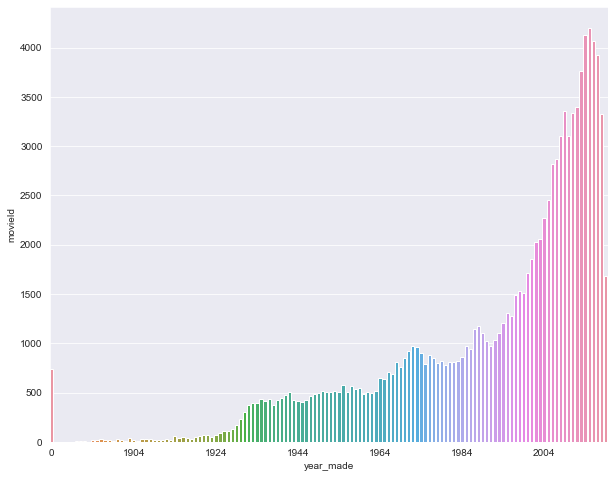

In [9]:
# visualizing how the year of the movies are distributed
df_mov_year = df_mov_gen.groupby("year_made").agg({"movieId":"count"}).reset_index()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(data=df_mov_year,  x="year_made", y="movieId")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.show()

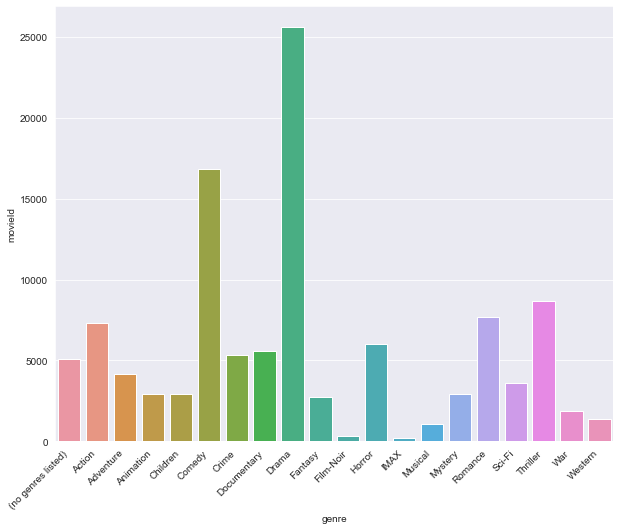

In [10]:
# visualizing how the genres of the movies are distributed
df_grp_gens = df_mov_gen.groupby("genre").agg({"movieId":"count"}).reset_index()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(data=df_grp_gens,  x="genre", y="movieId")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

#### Creating a `word-cloud` for title of movies base on the `genres`

In [11]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary
        with each word as a key, and the value represents the number of
        times that word appeared"""
    words = words.split()
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [12]:
def sentiment_word_extract():
    """This use to compile all the word and there frequency 
    in the individual category found in a particular column"""
    count = 0
    result = {}
    type_labels = df_mov_gen.genre.unique()
    genres = {}
    df_grp = df_mov_gen.groupby('genre')
    for pp in type_labels:
        genres[pp] = {}
        for row in df_grp.get_group(pp)['title']:
            genres[pp] = bag_of_words_count(row, genres[pp])
    return genres

In [13]:
from ipywidgets import interact, interact_manual, widgets
def iplotting():
    d = sentiment_word_extract()
    @interact_manual
    def selecting(genre_name = d.keys()):
        word_cloud_genre=WordCloud(width=1500, height=800, background_color='black', min_font_size=2,
                        min_word_length=3).generate(str(d[genre_name]))
        plt.figure(figsize=(20,10))
        plt.axis('off')
        plt.title(f'Word Cloud for {genre_name} Genre Movie titles',fontsize=30)
        plt.imshow(word_cloud_genre);
iplotting()

interactive(children=(Dropdown(description='genre_name', options=('Adventure', 'Animation', 'Children', 'Comed…

### Exploring `train` dataset

Exploring the train dataset to gain insight into the rating of `movies` and there various tags using the `genome scores and tags`

In [14]:
df_genome_scores = df_list[0].copy() # loading & assigning a varaible to the 'genome_scores' dataset
df_genome_tags = df_list[1].copy() # loading & assigning a varaible to the 'genome_tags' dataset
df_train = df_list[8].copy() # loading & assigning a varaible to the 'train' dataset


Merging the three dataframe plus `movies` dataset above to make one fine and informed dataframe

In [15]:
# Combining dataframe 'df_genome_scores' and 'df_genome_tags'
genome_comb = df_genome_scores.merge(df_genome_tags, how="left", on=["tagId"])
display(genome_comb.shape)
genome_comb.head(10)

(15584448, 4)

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s
5,1,6,0.14675,1950s
6,1,7,0.06350,1960s
7,1,8,0.20375,1970s
8,1,9,0.20200,1980s
9,1,10,0.03075,19th century


In [16]:
# grouping by 'movieId' and by calculating maximum 'relevance' corresponding to know the actual 'tag' of a 'movie'
genome_grp = genome_comb.groupby('movieId')[["relevance"]].max().reset_index()
display(genome_grp.shape)
genome_grp.head()

(13816, 2)

,movieId,relevance
0,1,0.99925
1,2,0.97600
2,3,0.97525
3,4,0.97525
4,5,0.96025


In [17]:
# Combinig the the grouped dataframe with the original dataframe to match each 'tag' to it respecitive 'relevance'
genome_comb1 = genome_grp.merge(genome_comb[['movieId', 'relevance', 'tag']], on=["movieId", "relevance"])

# drop duplicates to have a sync. merge of movie and `tag` and unccessary 'relevance' column
genome_comb1 = genome_comb1.drop_duplicates(subset=['movieId'])
genome_comb1 = genome_comb1.drop('relevance', axis=1)

genome_comb1.head()

,movieId,tag
0,1,toys
1,2,adventure
2,3,sequel
3,4,women
4,5,sequel


In [18]:
# merging ealier dataframe 'df_comb2' with tag and movie dataframe 'df_gem_comb1'
train_tags = df_train.merge(genome_comb1, how='left', on=["movieId"])
display(train_tags.shape)
train_tags.head(10)

(10000038, 5)

,userId,movieId,rating,timestamp,tag
0,5163,57669,4.0,1518349992,hit men
1,106343,5,4.5,1206238739,sequel
2,146790,5459,5.0,1076215539,alien
3,106362,32296,2.0,1423042565,sequels
4,9041,366,3.0,833375837,horror
5,120949,81768,3.0,1289595242,NaN
6,19630,62049,4.0,1246729817,george orwell
7,21066,2282,1.0,945785907,weird
8,117563,120474,4.0,1515108225,toys
9,144018,1997,5.0,1109967647,horror


In [19]:
#combining dataframe in index 8 and index 4 from the df_list
train_comb = train_tags.merge(df_movies, how="inner", on=["movieId"])
display(train_comb.shape)
train_comb.head(10)

(10000038, 8)

,userId,movieId,rating,timestamp,tag,title,genres,year_made
0,5163,57669,4.0,1518349992,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
1,87388,57669,3.5,1237455297,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
2,137050,57669,4.0,1425631854,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
3,120490,57669,4.5,1408228517,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
4,50616,57669,4.5,1446941640,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
5,99887,57669,0.5,1448839196,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
6,120194,57669,4.5,1479382352,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
7,847,57669,3.5,1232893563,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
8,47201,57669,4.5,1464351173,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008
9,94499,57669,4.5,1316689295,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008


In [20]:
# Checking for null value after merging
train_comb.isnull().sum()

userId            0
movieId           0
rating            0
timestamp         0
tag          130490
title             0
genres            0
year_made         0
dtype: int64

The tag features have a few null value in comparism with the large dataset, we will go ahead to replace those null values with keyword `unknown`

In [21]:
# making each genres into a list to be able to split
train_comb['tag'] = train_comb['tag'].fillna('unknown')

#### Converting the timestampe into `datetime` datatype and aslo into new features

In [22]:
train_comb['Rating_Datetime'] = pd.to_datetime(train_comb['timestamp'], unit='s')
train_comb.drop('timestamp', axis=1, inplace=True)

In [23]:
train_comb.head()

,userId,movieId,rating,tag,title,genres,year_made,Rating_Datetime
0,5163,57669,4.0,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2018-02-11 11:53:12
1,87388,57669,3.5,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2009-03-19 09:34:57
2,137050,57669,4.0,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2015-03-06 08:50:54
3,120490,57669,4.5,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2014-08-16 22:35:17
4,50616,57669,4.5,hit men,In Bruges (2008),"[Comedy, Crime, Drama, Thriller]",2008,2015-11-08 00:14:00


In [24]:
train_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   userId           int64         
 1   movieId          int64         
 2   rating           float64       
 3   tag              object        
 4   title            object        
 5   genres           object        
 6   year_made        object        
 7   Rating_Datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 686.6+ MB


In [25]:
# Converting 'year_made' into numeric datatype
train_comb["year_made"] = train_comb["year_made"].astype('int64')

In [26]:
# Let's have a look at the unique number of users
train_comb[["userId"]].nunique() 

userId    162541
dtype: int64

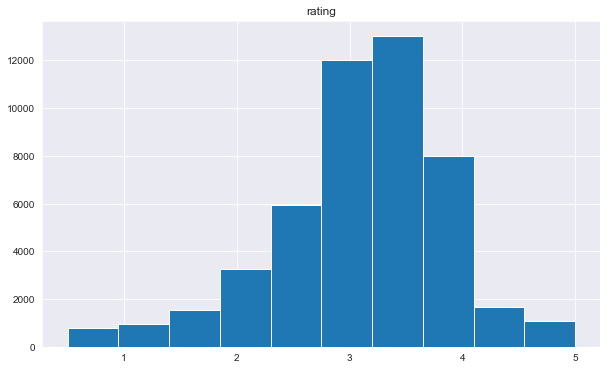

In [27]:
# distribution of mean rating
rating_grp = train_comb.groupby("movieId")[["rating"]].mean()
rating_grp.hist(figsize=(10, 6));

Bulk of the rating are between the value of `3-4` which bascially informed us while the dristibution is `left skewed`

In [28]:
#combining dataframe in index 8 and index 4 from the df_list
train_mod = train_tags.merge(df_mov_gen, how="inner", on=["movieId"])
display(train_mod.shape)
train_mod.head(10)

(27120044, 8)

,userId,movieId,rating,timestamp,tag,title,year_made,genre
0,5163,57669,4.0,1518349992,hit men,In Bruges (2008),2008,Comedy
1,5163,57669,4.0,1518349992,hit men,In Bruges (2008),2008,Crime
2,5163,57669,4.0,1518349992,hit men,In Bruges (2008),2008,Drama
3,5163,57669,4.0,1518349992,hit men,In Bruges (2008),2008,Thriller
4,87388,57669,3.5,1237455297,hit men,In Bruges (2008),2008,Comedy
5,87388,57669,3.5,1237455297,hit men,In Bruges (2008),2008,Crime
6,87388,57669,3.5,1237455297,hit men,In Bruges (2008),2008,Drama
7,87388,57669,3.5,1237455297,hit men,In Bruges (2008),2008,Thriller
8,137050,57669,4.0,1425631854,hit men,In Bruges (2008),2008,Comedy
9,137050,57669,4.0,1425631854,hit men,In Bruges (2008),2008,Crime


In [29]:
temp = train_mod.groupby(["genre", "title"])[["userId"]].count().reset_index()

In [30]:
temp[["genre", "title"]].to_csv('genre.csv')